In [1]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

import sys
sys.path.append("../..")
from analyzer.dumperReader.reader import *
from analyzer.driver.fileTools import *
from analyzer.driver.computations import *

In [2]:
dumperInput = DumperInputManager("/data_cms_upgrade/cuisset/supercls/alessandro_electrons/supercls-v2/")

In [9]:
nbins=100
score_axis = hist.axis.Regular(nbins, 0, 1+sys.float_info.epsilon, name="score", label="Association score")
def makeHistogram_comp_allTs(h:hist.Hist, reader:DumperReader):
    h.fill(score=ak.flatten(reader.associations.tsCLUE3D_recoToSim_CP_score, axis=None),
           CPid=ak.to_numpy(ak.flatten(reader.associations.tsCLUE3D_recoToSim_CP, axis=None)).view(dtype="int32"))
comp_allTs = HistogramComputation(
    hist.Hist(score_axis,
            hist.axis.IntCategory([0, 1], name="CPid", label="CP number", flow=False),
            name="allTs_CPassocScore"),
    makeHistogram_comp_allTs)

def makeHistogram_comp_tsInSupercls(h:hist.Hist, reader:DumperReader):
    h.fill(score=ak.flatten(superclusterToSim_df(reader.supercluster_df, reader.assocs_bestScore_recoToSim_df, tracksters_toDf(reader.tracksters_zipped[["ts_id", "barycenter_eta", "raw_pt"]])).score, axis=None))
comp_tsInSupercls = HistogramComputation(
    hist.Hist(score_axis,
            name="tsInSupercls_CPassocScore"),
    makeHistogram_comp_tsInSupercls)

# Association score of tracksters in a supercluster holding seed
def makeHistogram_comp_tsInSeedSupercls(h:hist.Hist, reader:DumperReader):
    df = trackster_joinSupercluster(
        tracksters_toDf(tracksters_getSeeds(reader.tracksters_zipped[["ts_id", "barycenter_eta", "raw_pt"]])),
        tracksters_toDf(reader.tracksters_zipped[["ts_id"]]),
        reader.supercluster_df
    ).join(reader.assocs_bestScore_recoToSim_df()[["score"]])

    h.fill(score=df.score)

comp_tsInSeedSupercls = HistogramComputation(
    hist.Hist(score_axis,
            name="tsInSeedSupercls_CPassocScore"),
    makeHistogram_comp_tsInSeedSupercls)


res = runComputations([comp_allTs, comp_tsInSupercls, comp_tsInSeedSupercls], dumperInput, max_workers=10)
res = {"allTs" : res[0], "tsInSupercls" : res[1], "tsInSeedSupercls":res[2]}

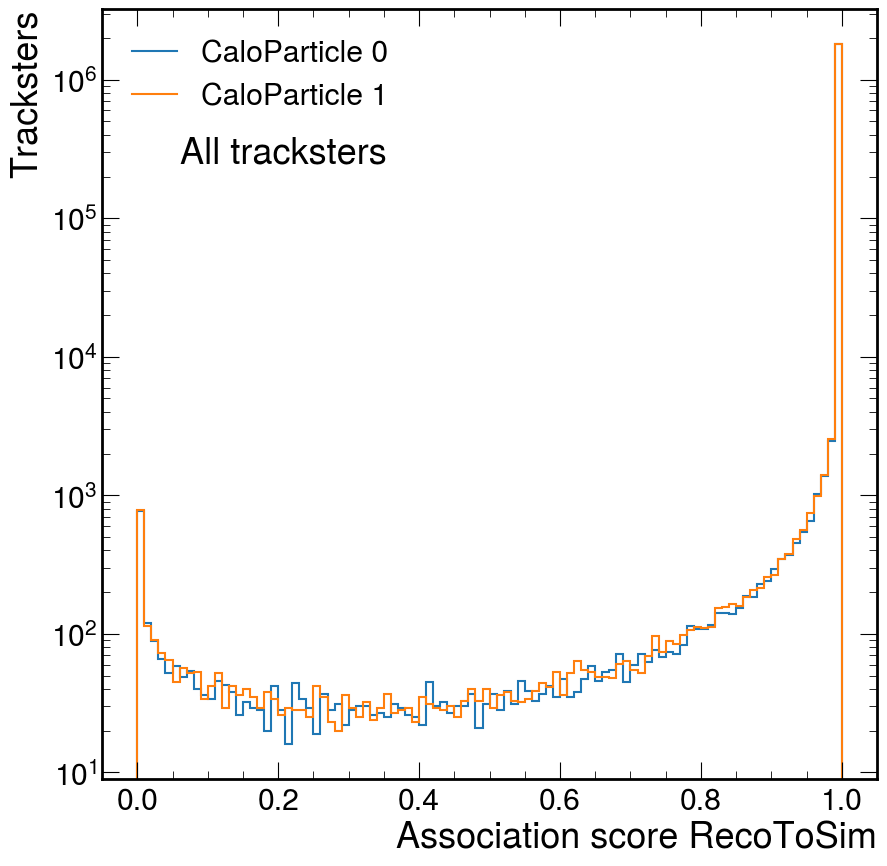

In [10]:
hep.histplot([res["allTs"][:, 0], res["allTs"][:, 1]], yerr=False, label=["CaloParticle 0", "CaloParticle 1"], flow="hint")
plt.yscale("log")
plt.ylabel("Tracksters")
plt.xlabel("Association score RecoToSim")
plt.text(0.1, 0.8, "All tracksters", transform=plt.gca().transAxes)
plt.legend()

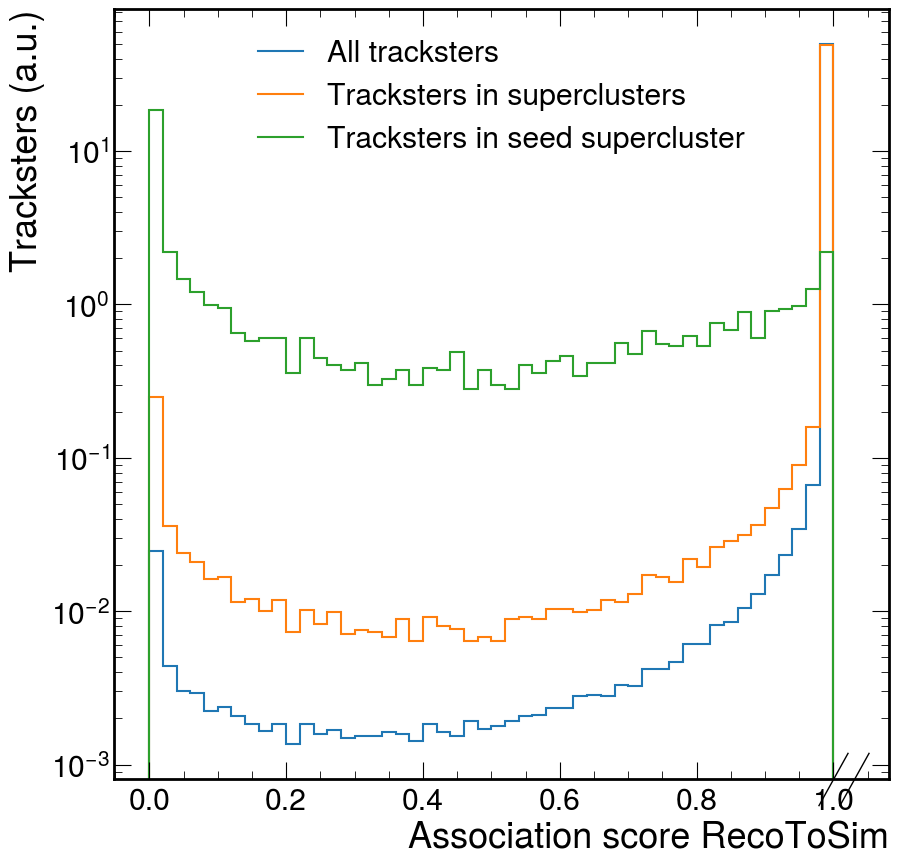

In [12]:
rebin = 2
hep.histplot([res["allTs"][::hist.rebin(rebin), ::hist.sum], res["tsInSupercls"][::hist.rebin(rebin)], res["tsInSeedSupercls"][::hist.rebin(rebin)]], 
             yerr=False, flow="hint", density=True,
             label=["All tracksters", "Tracksters in superclusters", "Tracksters in seed supercluster"])
plt.yscale("log")
plt.ylabel("Tracksters (a.u.)")
plt.xlabel("Association score RecoToSim")
#plt.text(0.1, 0.8, "All tracksters", transform=plt.gca().transAxes)
plt.legend()

In [6]:
res["tsInSeedSupercls"]

Hist(Regular(100, 0, 1, name='score', label='Association score'), storage=Double()) # Sum: 3373.0 (3611.0 with flow)